<a href="https://colab.research.google.com/github/dcher95/universe7/blob/pytorch/notebooks/Exploring_Barlow_Twins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Barlow Twins

Barlow Twins approaches Self Supervised Learning (SSL) slightly differently to prior work; while other solutions mainly tackle the first goal of **invariance** (similar images have similar embeddings), the Barlow Twins method also prioritizes the goal of **reducing redundancy**.

Invariance and reduced redundancy are represented and illustrated in more detail in the loss function.

At a high-level the model:
  1. Creates two augmentations of an image
  2. Takes a prediction of each of them -> representational embedding
  3. Creates a cross-correlation matrix, which after training inches closer to an identity matrix

<img src="https://i.ibb.co/tZsBrPn/Barlow-Twins-architecture.png"
alt="drawing" width="600"/>

<small> Barlow Twins Architecture. Taken from the <a href="https://arxiv.org/abs/2103.03230">original paper</a>.</small>

The authors released various checkpoints which are now available on the Hugging Face [hub](https://huggingface.co/models?other=depth_anything).

Useful resources:

* Original paper: https://arxiv.org/abs/2103.03230.
* Github: https://github.com/facebookresearch/barlowtwins?tab=readme-ov-file.
* Model Checkpoint is available through torch: torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')

[Keras documentation](https://keras.io/examples/vision/barlow_twins/) is used as reference


In [1]:
from torchvision import datasets, transforms, models
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm

### Define Data Augmentations
- These should look very similar to SimCLR or MoCo. Different SSL techniques have a lot of overlap in data augmentations.

In [2]:
# Data augmentations similar to SimCLR
transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.4)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### Visualize a batch of original and augmented images!

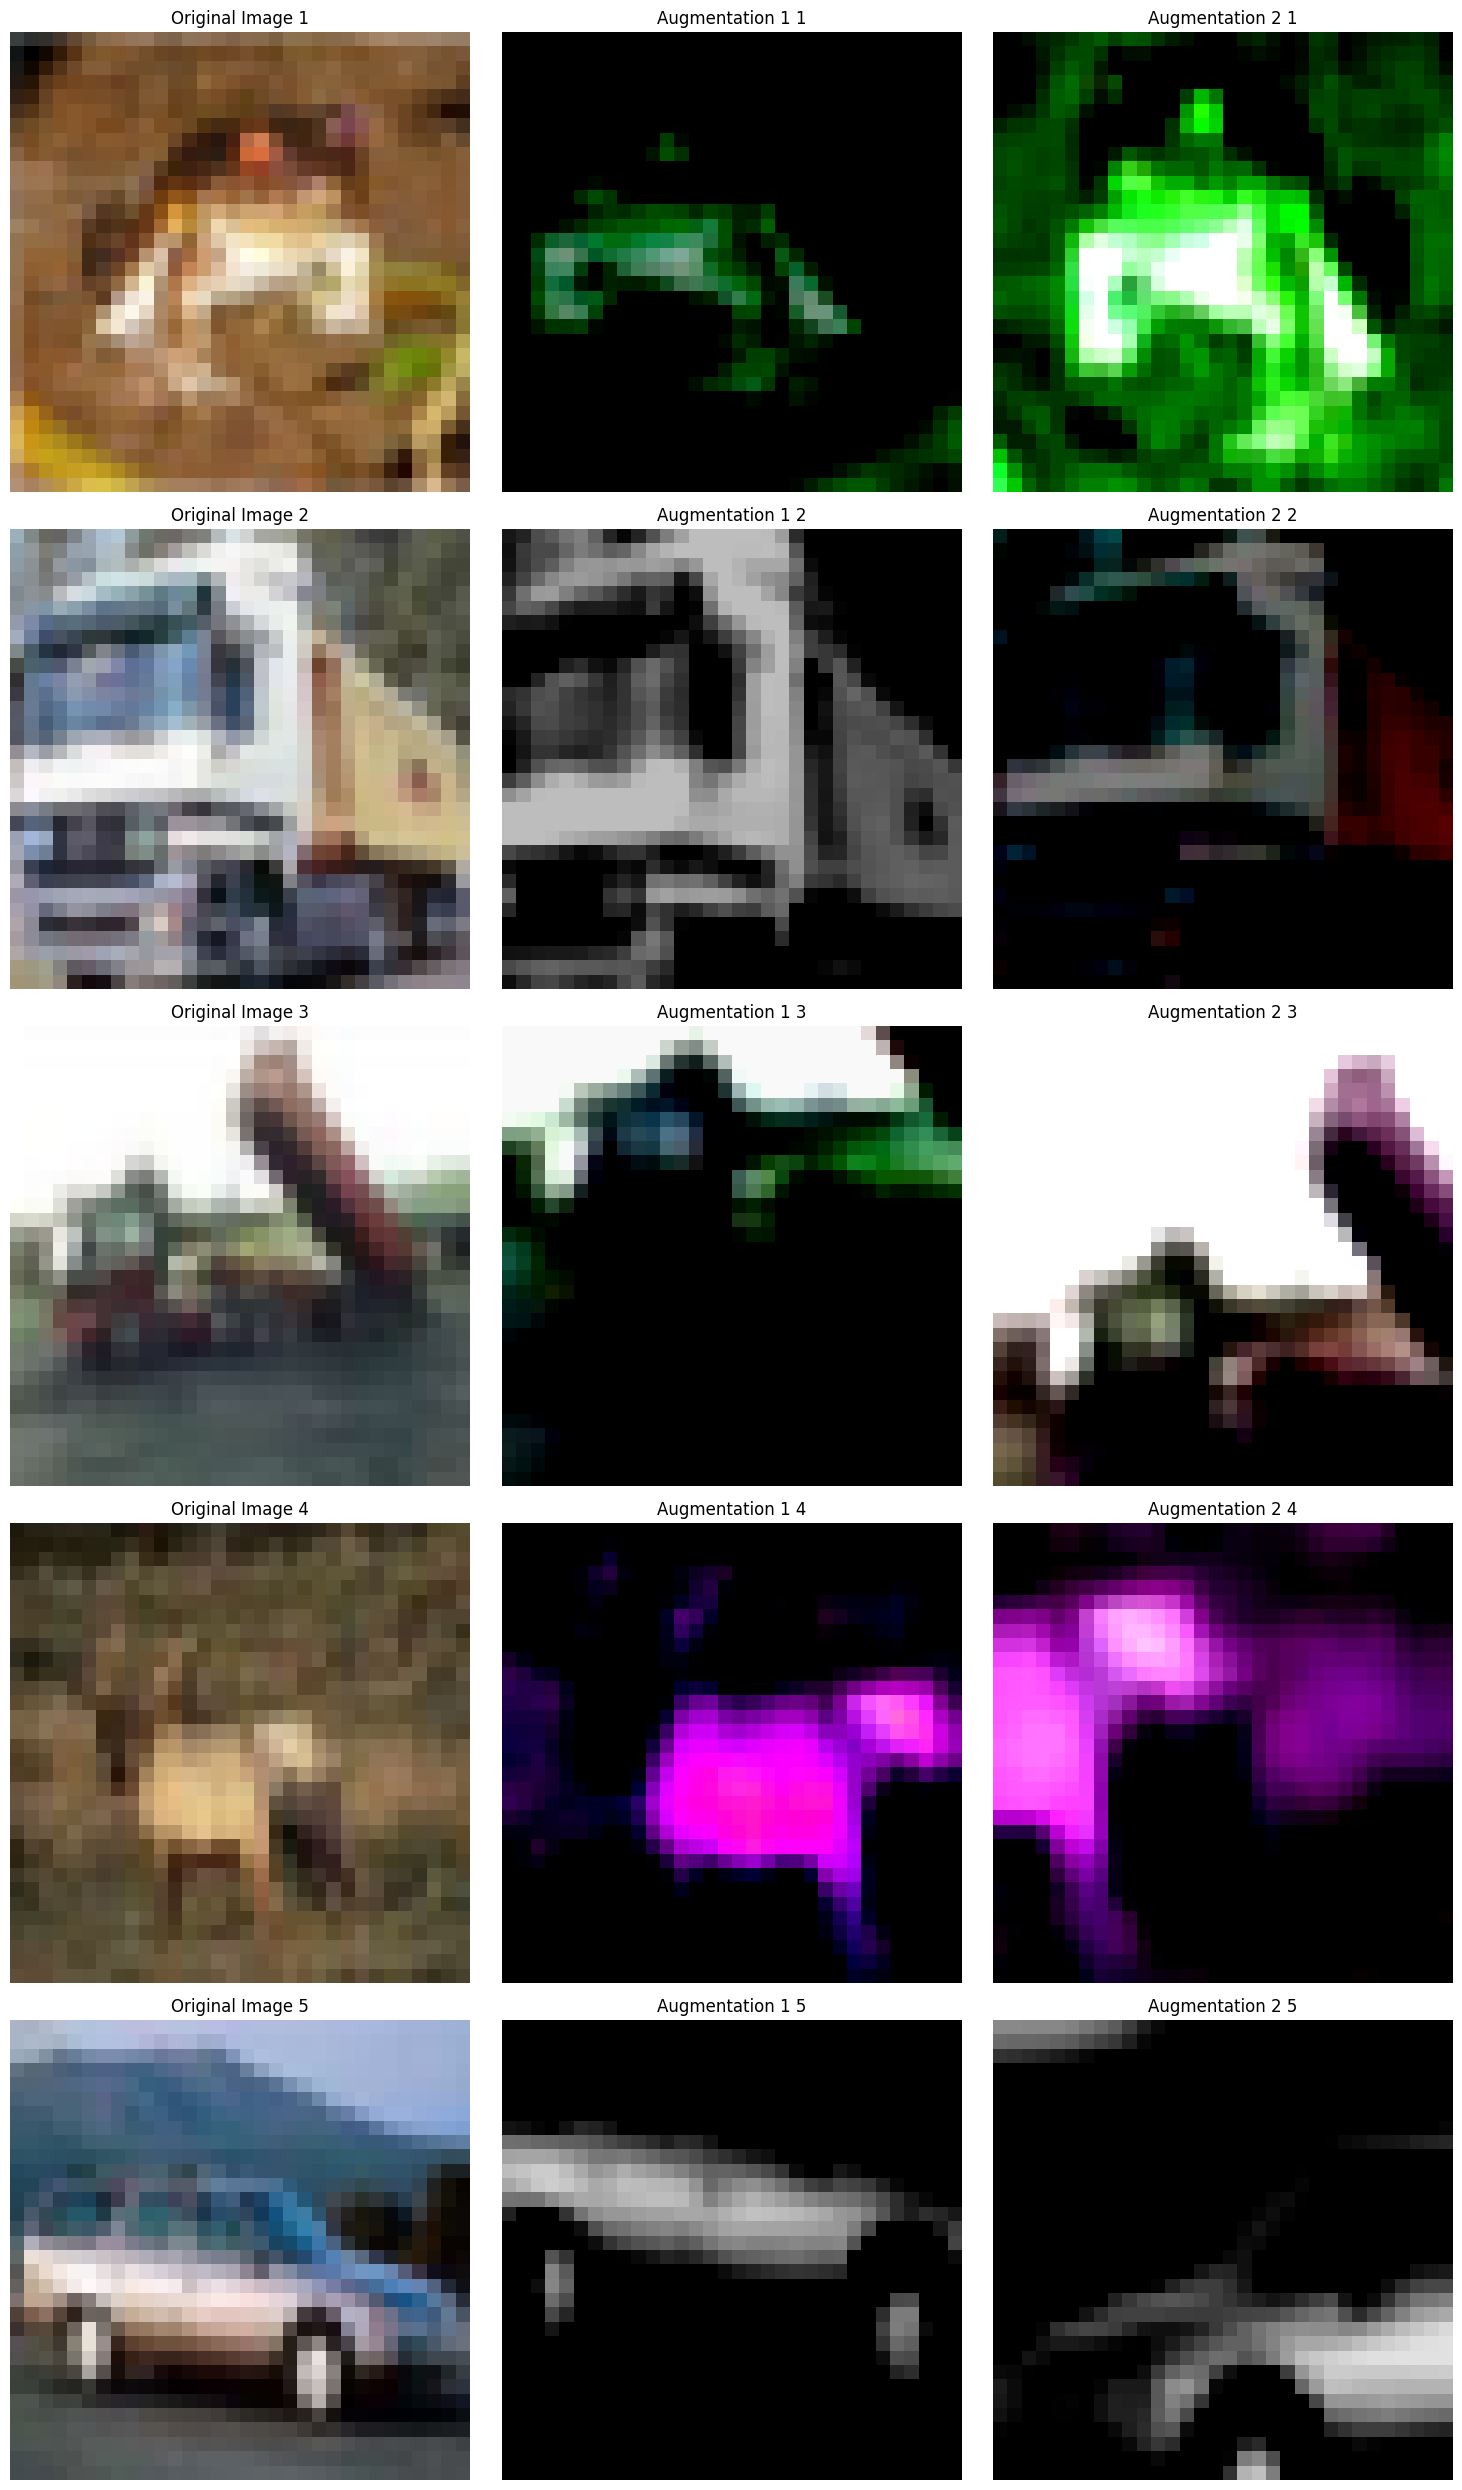

In [3]:
def visualize_batch_augmentations(dataset, transform, num_images=5):
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))

    for i in range(num_images):
        img, _ = dataset[i]

        # Convert to image and transform
        to_pil = transforms.ToPILImage()
        img_pil = to_pil(img)

        img1 = transform(img_pil)
        img2 = transform(img_pil)

        # Plotting
        axes[i, 0].imshow(img.permute(1, 2, 0).cpu())
        axes[i, 0].set_title(f"Original Image {i+1}")
        axes[i, 0].axis("off")
        axes[i, 1].imshow(img1.permute(1, 2, 0).cpu())
        axes[i, 1].set_title(f"Augmentation 1 {i+1}")
        axes[i, 1].axis("off")
        axes[i, 2].imshow(img2.permute(1, 2, 0).cpu())
        axes[i, 2].set_title(f"Augmentation 2 {i+1}")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

data = datasets.CIFAR10(root='./data', train=True, download=False,
                        transform=transforms.Compose([transforms.ToTensor()]))

visualize_batch_augmentations(data, transform, num_images=5)


### Data Loader

In [4]:
train_dataset = datasets.CIFAR10(root='./data',
                                 train=True,
                                 download=True,
                                 transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

Files already downloaded and verified


#### Barlow Twins Loss

**Invariance**: Ensures that the embeddings of two augmented views are similar.
- Mechanically: Diagonal Elements ~ 1

**Redundancy Reduction**: Prevents the embeddings from collapsing by ensuring that different dimensions of the embeddings capture unique information.
- Mechanically: Off-Diagonal Elements ~ 0

TLDR; Minimizing the difference between the *cross-correlation matrix* and *identity matrix*.

  $\mathcal{L}_{\mathcal{B} \mathcal{T}} \triangleq \underbrace{\sum_i\left(1-\mathcal{C}_{i i}\right)^2}_{\text {invariance term }}+\lambda \underbrace{\sum_i \sum_{j \neq i} \mathcal{C}_{i j}{ }^2}_{\text {redundancy reduction term }}$

**This can be visually seen in the Cross-Correlation Matrix visualization below**

In [5]:
class BarlowTwinsLoss(torch.nn.Module):
    def __init__(self, lambda_param=0.005):
        super(BarlowTwinsLoss, self).__init__()
        self.lambda_param = lambda_param

    def forward(self, z1, z2):

        # Normalize z1 and z2
        z1_norm = (z1 - z1.mean(0)) / z1.std(0)
        z2_norm = (z2 - z2.mean(0)) / z2.std(0)

        # Cross-correlation matrix
        c = torch.mm(z1_norm.T, z2_norm) / z1.size(0)

        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum() # Invariance
        off_diag = (c - torch.eye(c.size(0), device=c.device)).pow_(2).sum() # Redundancy reduction

        loss = on_diag + self.lambda_param * off_diag

        return loss


### Backbone & Projection Head
- Encoder network is a resnet
- Projector network is a 3-layer MLP -> Creates the model embeddings

In [6]:
class BarlowTwins(torch.nn.Module):
    def __init__(self):
        super(BarlowTwins, self).__init__()

        # BarlowTwins uses a Resnet50 backbone, but we use Resnet18 for compute purposes
        # Last layer is removed
        self.backbone = models.resnet18(pretrained=False)
        self.backbone.fc = torch.nn.Identity()

        # 3 Layer MLP
        self.projection = torch.nn.Sequential(
            torch.nn.Linear(512, 2048),
            torch.nn.BatchNorm1d(2048),
            torch.nn.ReLU(),

            torch.nn.Linear(2048, 2048),
            torch.nn.BatchNorm1d(2048),
            torch.nn.ReLU(),

            torch.nn.Linear(2048, 2048),
        )

    def forward(self, x1, x2):
        z1 = self.projection(self.backbone(x1))
        z2 = self.projection(self.backbone(x2))
        return z1, z2

### Let's Model!
- The authors use LARS optimizer, train for 1000 epochs with a batch size of 2048. They use a learning rate warmup followed by a cosine-decay schedule.
  - It took 100 hours on 32 V100s!

The code below is heavily simplified since the purpose is to understand the methodology :)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BarlowTwins().to(device)
criterion = BarlowTwinsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
num_epochs = 10
total_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Initialize tqdm progress bar for the current epoch
    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

        for (x, _) in tepoch:
            x1 = x.to(device)
            x2 = x.to(device)

            # Forward pass: compute embeddings for two views
            z1, z2 = model(x1, x2)

            # Compute Barlow Twins loss
            loss = criterion(z1, z2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            tepoch.set_postfix(loss=running_loss / len(tepoch))

    total_losses.append(running_loss / len(train_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")


Epoch [1/10]: 100%|██████████| 391/391 [01:10<00:00,  5.55batch/s, loss=305]


Epoch [1/10], Loss: 305.2809864249071


Epoch [2/10]: 100%|██████████| 391/391 [01:01<00:00,  6.31batch/s, loss=190]


Epoch [2/10], Loss: 190.45069003288094


Epoch [3/10]: 100%|██████████| 391/391 [01:01<00:00,  6.40batch/s, loss=187]


Epoch [3/10], Loss: 186.87908346268833


Epoch [4/10]: 100%|██████████| 391/391 [00:57<00:00,  6.78batch/s, loss=186]


Epoch [4/10], Loss: 185.90821260808374


Epoch [5/10]: 100%|██████████| 391/391 [00:58<00:00,  6.69batch/s, loss=186]


Epoch [5/10], Loss: 185.7640825744785


Epoch [6/10]: 100%|██████████| 391/391 [00:57<00:00,  6.85batch/s, loss=186]


Epoch [6/10], Loss: 185.96307427681924


Epoch [7/10]: 100%|██████████| 391/391 [00:56<00:00,  6.95batch/s, loss=186]


Epoch [7/10], Loss: 186.21033694372153


Epoch [8/10]: 100%|██████████| 391/391 [00:59<00:00,  6.61batch/s, loss=186]


Epoch [8/10], Loss: 186.21122995361952


Epoch [9/10]: 100%|██████████| 391/391 [00:57<00:00,  6.85batch/s, loss=186]


Epoch [9/10], Loss: 186.12490360816116


Epoch [10/10]: 100%|██████████| 391/391 [00:57<00:00,  6.78batch/s, loss=186]

Epoch [10/10], Loss: 185.6536191272004


### Loss Plotting

Here is some code if you want to generate the loss plots.

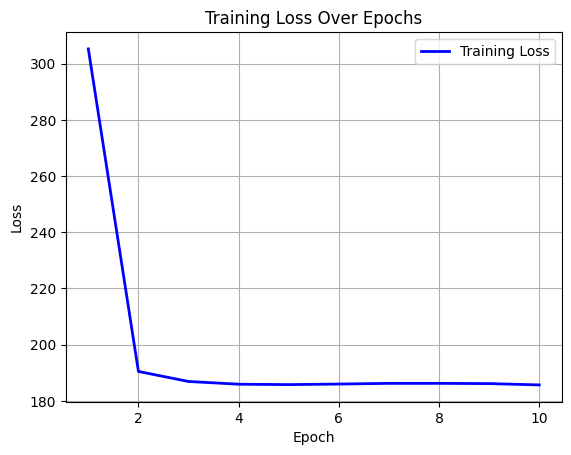

In [9]:
plt.plot(range(1, num_epochs + 1), total_losses, label='Training Loss', color='blue', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


The authors ran the model for 160 epochs, which takes a while. The snippit below shows the loss plot after running it for 75 epochs. Definitely could use even more epochs.

<img src="https://i.ibb.co/TcpRbyN/BT-loss-plot.png"
alt="drawing" width="600"/>

### Visualize Cross-Correlation Matrix
- The goal is to have the cross-correlation matrix resemble the identity matrix.
- The code below visualizes the cross-correlation matrix for the last epoch. It also zooms into the top-left corner to see it a little better.

In [10]:
def visualize_correlation_matrix(z1, z2, matrix_size=10, top_left = False):
    # Normalize the embeddings
    z1_norm = (z1 - z1.mean(0)) / z1.std(0)
    z2_norm = (z2 - z2.mean(0)) / z2.std(0)

    # Compute the cross-correlation matrix
    c = torch.mm(z1_norm.T, z2_norm) / z1.size(0)  # [D, D]
    c = c.cpu().detach().numpy()

    # Slice the top-left matrix_size x matrix_size portion
    if top_left:
      c_top_left = c[:matrix_size, :matrix_size]
    else:
      c_top_left = c

    # Plot the top-left of the cross-correlation matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(c_top_left, annot=False, cmap='coolwarm', center=0)
    if top_left:
      plt.title(f'Top Left {matrix_size}x{matrix_size} Cross-Correlation Matrix')
    else:
      plt.title(f'Cross-Correlation Matrix')
    plt.show()

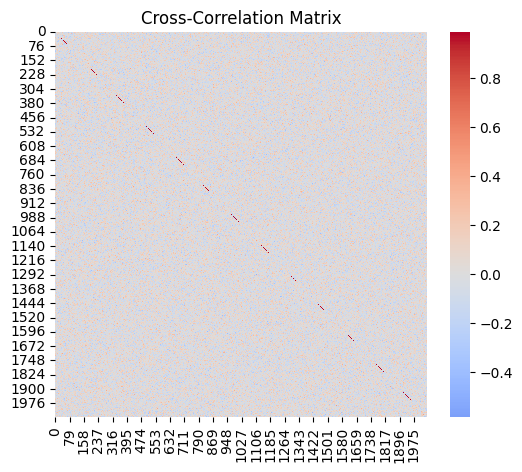

None

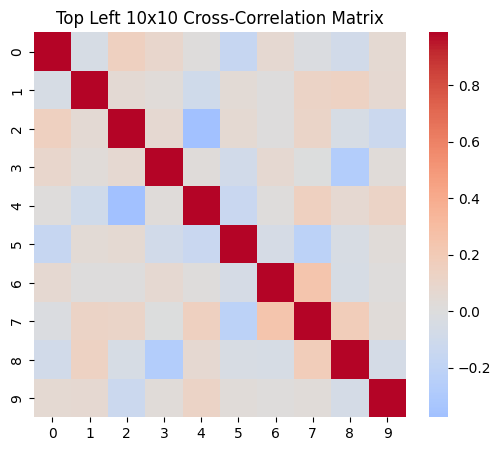

None

In [11]:
display(visualize_correlation_matrix(z1, z2))
display(visualize_correlation_matrix(z1, z2, top_left = True))

### Compare to 75 epochs
- Interesting to see how it has become more 'identity matrix' like

<img src="https://i.ibb.co/2tvhp0P/many-epochs-full-corr.png"
alt="drawing" width="600"/>

<img src="https://i.ibb.co/qNBT349/top-left-full-corr.png"
alt="drawing" width="600"/>
